# _Influencia de la duración de piststops en carreras de F1_

* Hipótesis:  

> Mejor media de tiempos por carrera y temporada mejora las posiciones en carrera y al final de temporada 

* hipótesis secundaria  

> También se cumple para los constructores  

* bonus: Diferencias entre conductores de una mismo equipo

<center><img src="F1_logo.jpg"  width="200"><img src="F170.jpg"  width="400"></center> <p>
<center><img src="pitStopAstonMartin.jpg"  width="600" height="300"></center>


### <span style="color:RED"> DATASET</span>

#### CSV's EXTRAIDOS DE ergast.com  

* Ofrece resultados de todas las carreras desde 1950 hasta hoy.  

* Paquete ergast_py  
https://pypi.org/project/ergast-py/

* API con datos actualizados tras cada carrera  
  
  * API documentación http://ergast.com/mrd/  
    
* Libreria propia para acceder a la API  
    pyERGAST


#### Ofrecen todo el paquete de csv hasta la carrera más reciente  
* f1db_csv.zip  
http://ergast.com/downloads/f1db_csv.zip  

* Diagrama de la BD  
http://ergast.com/images/ergast_db.png  

* Esquema de la BD  
http://ergast.com/docs/f1db_user_guide.txt  

Cada csv tiene una sola base de datos en UTF-8  
La primera línea son las cabeceras de las columnas. 




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import re

* 13 csv

In [4]:
circuits=pd.read_csv(r'./circuits.csv')
constructor_results=pd.read_csv(r'./constructor_results.csv')
constructor_standings=pd.read_csv(r'./constructor_standings.csv')
driver_standings=pd.read_csv(r'./driver_standings.csv')
drivers=pd.read_csv (r'./drivers.csv')
lap_times=pd.read_csv(r'./lap_times.csv')
pit_stops=pd.read_csv(r'./pit_stops.csv')
qualifying=pd.read_csv(r'./qualifying.csv')
races=pd.read_csv(r'./races.csv')
results=pd.read_csv(r'./results.csv')
seasons=pd.read_csv(r'./seasons.csv')
sprint_results=pd.read_csv(r'./sprint_results.csv')
status=pd.read_csv(r'./status.csv')


* Para el primer proyecto EDA, los más interesantes son:  

    * pit stops                     | *pit_stops*  
    * resultados                    | *results.csv*  
    * conductores                   |  *drivers.csv*  
    * carreras                      |  *races.csv*  
    * resultados de constructores por campeonato   | *constructor_standings.csv*  
    * resultados de constructores por carrera   | *constructor_results.csv*  
    * status (finalizado/otros)     | *status.csv*
    * tiempo por vuelta             | *lap_times.csv*


---------------

## <center><span style="color:RED"> *PIT STOPS*</span></center>

---------------

In [5]:
pit_stops.head(2)

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021


In [6]:
# cambiar tiempo en milisegundos a int
pit_stops["milliseconds"].astype(int).sample(2)

6244    21543
3848    33689
Name: milliseconds, dtype: int32

In [7]:
pit_stops.drop(['time', 'duration'], axis=1, inplace=True)
#quitar hora de parada y tiempo en segundos

In [8]:
pit_stops

,raceId,driverId,stop,lap,milliseconds
0,841,153,1,1,26898
1,841,30,1,1,25021
2,841,17,1,11,23426
3,841,4,1,12,23251
4,841,13,1,13,23842
...,...,...,...,...,...
9891,1105,847,2,45,22054
9892,1105,1,2,50,22731
9893,1105,815,2,50,21537
9894,1105,846,3,50,22062


In [9]:
# media de tiempo en milisegundos de pitstops por carrera/conductor

pit_stops_mean=pit_stops.groupby(["raceId", "driverId"])["milliseconds"].mean()
pit_stops_mean

raceId  driverId
841     1           23213.0
        2           24046.0
        3           23716.0
        4           24055.0
        5           24865.0
                     ...   
1105    852         22092.5
        855         23159.5
        856         22249.0
        857         22616.0
        858         23205.0
Name: milliseconds, Length: 4837, dtype: float64

In [10]:
pit_stops.info()
# no tiene datos nulos
#datos cualitativos raceId, driverId, stop, lap

#datos cuantitativos: milliseconds

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   raceId        9896 non-null   int64
 1   driverId      9896 non-null   int64
 2   stop          9896 non-null   int64
 3   lap           9896 non-null   int64
 4   milliseconds  9896 non-null   int64
dtypes: int64(5)
memory usage: 386.7 KB


---------------

## <center><span style="color:RED"> *RACES*</span></center>

---------------

In [11]:
# quitar columnas que no vamos a usar

races.drop(['url', 'time', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)

In [18]:
races.sort_values("year")

,raceId,year,round,circuitId,name,date
838,839,1950,7,14,Italian Grand Prix,1950-09-03
837,838,1950,6,55,French Grand Prix,1950-07-02
836,837,1950,5,13,Belgian Grand Prix,1950-06-18
835,836,1950,4,66,Swiss Grand Prix,1950-06-04
834,835,1950,3,19,Indianapolis 500,1950-05-30
...,...,...,...,...,...,...
1080,1099,2023,2,77,Saudi Arabian Grand Prix,2023-03-19
1079,1098,2023,1,3,Bahrain Grand Prix,2023-03-05
1099,1119,2023,21,80,Las Vegas Grand Prix,2023-11-19
1088,1108,2023,10,9,British Grand Prix,2023-07-09


In [16]:
# carreras desde la 842 en adelante, que son las que tienen información en pit_stops

races[["raceId", "year", "circuitId", "name"]][races.raceId>=842]

,raceId,year,circuitId,name
840,842,2011,2,Malaysian Grand Prix
841,843,2011,17,Chinese Grand Prix
842,844,2011,5,Turkish Grand Prix
843,845,2011,4,Spanish Grand Prix
844,846,2011,6,Monaco Grand Prix
...,...,...,...,...
1096,1116,2023,69,United States Grand Prix
1097,1117,2023,32,Mexico City Grand Prix
1098,1118,2023,18,São Paulo Grand Prix
1099,1119,2023,80,Las Vegas Grand Prix


In [19]:
races.info()

#todo valores cualitativos, para unir con resultados y clasificar por raceId o año

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raceId     1101 non-null   int64 
 1   year       1101 non-null   int64 
 2   round      1101 non-null   int64 
 3   circuitId  1101 non-null   int64 
 4   name       1101 non-null   object
 5   date       1101 non-null   object
dtypes: int64(4), object(2)
memory usage: 51.7+ KB


---------------

## <center><span style="color:RED"> *RESULTS*</span></center>

---------------

In [206]:
# resultados de cada carrera, identificador de carrera, conductor, constructor, posición, vueltas, tiempo total, puntos, vuelta rapida, tiempo de vuelta rapida
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 20822 to 25971
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           2579 non-null   int64  
 1   driverId         2579 non-null   int64  
 2   constructorId    2579 non-null   int64  
 3   grid             2579 non-null   int64  
 4   position         2579 non-null   object 
 5   points           2579 non-null   float64
 6   laps             2579 non-null   int64  
 7   milliseconds     2579 non-null   object 
 8   fastestLap       2579 non-null   object 
 9   fastestLapTime   2579 non-null   object 
 10  fastestLapSpeed  2579 non-null   object 
 11  statusId         2579 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 261.9+ KB


In [207]:
# De los pitstops cambió la norma para evitar repostajes por seguridad en 2009

# los pitstops.csv tiene información desde entonces en adelante.       carrera 842

# Nos quedamos con los resultados de conductores que han acabado las carreras.      statusId==1

results.sample(2)

,raceId,driverId,constructorId,grid,position,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId
25569,1082,840,117,17,10,1.0,70,5819979,64,1:17.421,202.782,1
24157,1008,1,131,1,1,25.0,71,5229066,70,1:11.795,216.065,1


In [26]:
# quitar columnas que no vamos a utilizar

results.drop(['positionText', 'positionOrder','number', 'resultId', 'time', 'rank'], axis=1, inplace=True)

In [27]:
# statusId=1 indica que el conductor terminó la carrera
# status[["statusId","status"]][status.status=='Finished']

results=results[(results.raceId>842)&(results.statusId==1)]
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 20822 to 25971
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           2579 non-null   int64  
 1   driverId         2579 non-null   int64  
 2   constructorId    2579 non-null   int64  
 3   grid             2579 non-null   int64  
 4   position         2579 non-null   object 
 5   points           2579 non-null   float64
 6   laps             2579 non-null   int64  
 7   milliseconds     2579 non-null   object 
 8   fastestLap       2579 non-null   object 
 9   fastestLapTime   2579 non-null   object 
 10  fastestLapSpeed  2579 non-null   object 
 11  statusId         2579 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 261.9+ KB


In [28]:
results["milliseconds"].describe()

count        2579
unique       2577
top       5152531
freq            2
Name: milliseconds, dtype: object

In [36]:
# cambiar valores \N de milliseconds a 0
results["milliseconds"].replace('\\N', 0, inplace=True)

In [37]:
# cambiar tipo a entero
results['milliseconds'].astype(int)

20822    5818226
20823    5823424
20824    5825781
20825    5828226
20826    5831674
          ...   
25967    5347182
25968    5349818
25969    5351470
25970    5352359
25971    5353356
Name: milliseconds, Length: 2579, dtype: int32

In [78]:
# Resultados de cada carrera, identificadores de carrera, piloto, posición inicial/final, puntos, vueltas, tiempos

results.sample(4)

,raceId,driverId,constructorId,grid,position,points,laps,total_time,fastestLap,fastestLapTime,fastestLapSpeed,statusId
22268,906,8,6,10,10,1.0,70,6006508,68,1:18.529,199.921,1
21624,876,814,10,16,12,0.0,60,5553559,59,1:29.086,207.103,1
25074,1057,1,131,2,15,0.0,51,8034078,43,1:44.769,206.270,1
25371,1072,849,3,16,12,0.0,50,7658367,49,1:32.751,239.635,1


In [68]:
results.rename(columns={'milliseconds':'total_time'}, inplace=True)

In [65]:
# merge con medias de tiempo de pitstops, races, y drivers

In [69]:
r1=pd.merge(results, pit_stops, on=["raceId", "driverId"])

In [70]:
r1.sample(4)

,raceId,driverId,constructorId,grid,position,points,laps,total_time,fastestLap,fastestLapTime,fastestLapSpeed,statusId,stop,lap,milliseconds
4407,1062,849,3,18,7,6.0,70,7561109,62,1:22.831,190.406,1,2,3,39081
1728,909,1,131,20,3,15.0,67,5645444,53,1:19.908,206.066,1,3,50,19868
1468,896,13,6,5,4,12.0,60,5513879,54,1:28.886,207.569,1,1,8,23579
2351,945,13,3,8,8,4.0,55,6007926,33,1:46.984,186.891,1,2,26,22710


In [76]:
r1[["raceId", "driverId", 'grid', 'position', 'milliseconds']].sample(3)


# grid: posición inicial
# position: posición final


,raceId,driverId,milliseconds
3456,1011,842,24484
2112,936,826,21574
4682,1078,817,19280


In [79]:
races

,raceId,year,round,circuitId,name,date
0,1,2009,1,1,Australian Grand Prix,2009-03-29
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05
2,3,2009,3,17,Chinese Grand Prix,2009-04-19
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26
4,5,2009,5,4,Spanish Grand Prix,2009-05-10
...,...,...,...,...,...,...
1096,1116,2023,18,69,United States Grand Prix,2023-10-22
1097,1117,2023,19,32,Mexico City Grand Prix,2023-10-29
1098,1118,2023,20,18,São Paulo Grand Prix,2023-11-05
1099,1119,2023,21,80,Las Vegas Grand Prix,2023-11-19


In [87]:
races09_23=pd.merge(r1,races, on=['raceId'])

In [88]:
races09_23.drop(['round','circuitId','date'], axis=1, inplace=True)

In [89]:
races09_23.sample(3)

,raceId,driverId,constructorId,grid,position,points,laps,total_time,fastestLap,fastestLapTime,fastestLapSpeed,statusId,stop,lap,milliseconds,year,name
538,862,818,5,24,16,0.0,56,5838685,48,1:40.019,196.198,1,1,11,22835,2012,Chinese Grand Prix
3815,1033,1,131,1,1,26.0,70,5772473,70,1:16.627,205.823,1,1,3,22320,2020,Hungarian Grand Prix
5231,1100,832,6,5,12,0.0,58,9164965,53,1:20.467,236.131,1,1,7,18319,2023,Australian Grand Prix


In [107]:
races09_23.columns

Index(['raceId', 'driverId', 'constructorId', 'grid', 'position', 'points',
       'laps', 'total_time', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed',
       'statusId', 'stop', 'lap', 'milliseconds', 'year', 'name'],
      dtype='object')

In [129]:
races09_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5309 entries, 0 to 5308
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           5309 non-null   int64  
 1   driverId         5309 non-null   int64  
 2   constructorId    5309 non-null   int64  
 3   grid             5309 non-null   int64  
 4   position         5309 non-null   object 
 5   points           5309 non-null   float64
 6   laps             5309 non-null   int64  
 7   total_time       5309 non-null   object 
 8   fastestLap       5309 non-null   object 
 9   fastestLapTime   5309 non-null   object 
 10  fastestLapSpeed  5309 non-null   object 
 11  statusId         5309 non-null   int64  
 12  stop             5309 non-null   int64  
 13  lap              5309 non-null   int64  
 14  milliseconds     5309 non-null   int64  
 15  year             5309 non-null   int64  
 16  name             5309 non-null   object 
dtypes: float64(1),

In [154]:
### No hay valores NaN, pero hay cadenas '\N'
# races09_23.isna().sum()
races09_23[['fastestLap', 'fastestLapSpeed', 'fastestLapTime']].replace('\\N', -1)

In [159]:
## graficas   carrera/media pit_stop

## media pitstop/ puestos ganados

---------------

## <center><span style="color:RED"> *DRIVERS*</span></center>

---------------

In [39]:
# unir nombre apellido
drivers['fullname']=drivers['forename']+" "+drivers['surname']

In [41]:
# borrar columnas

drivers.drop(['nationality', 'code', 'dob', 'number', 'url', 'forename', 'surname'], axis=1, inplace=True)

In [43]:
# Información básica de cada conductor, id, alias, nombre completo

# todas cualitativas para mezclar con results

drivers[drivers.driverId==4]

,driverId,driverRef,fullname
3,4,alonso,Fernando Alonso


---------------

## <center><span style="color:RED"> *LAP TIMES*</span></center>

---------------

In [45]:
lap_times.info()

# sin valores nulos
# variable cuantitativa, tiempo en milisegundos por vuelta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546037 entries, 0 to 546036
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        546037 non-null  int64 
 1   driverId      546037 non-null  int64 
 2   lap           546037 non-null  int64 
 3   position      546037 non-null  int64 
 4   time          546037 non-null  object
 5   milliseconds  546037 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 25.0+ MB


In [44]:
lap_times.sample(4)

,raceId,driverId,lap,position,time,milliseconds
298664,66,13,14,1,1:31.053,91053
242773,120,2,65,9,1:24.758,84758
455282,1015,844,6,13,1:19.151,79151
208611,153,50,55,15,1:20.895,80895


In [46]:
# cambiar tipo de tiempo en milisegundos a int
lap_times["milliseconds"].astype(int)

0         98109
1         93006
2         92713
3         92803
4         92342
          ...  
546032    79035
546033    79096
546034    79502
546035    78922
546036    79271
Name: milliseconds, Length: 546037, dtype: int32

In [49]:
# media de tiempo por vuelta, por carrera y conductor
lap_times_race_mean=lap_times.groupby(['raceId', 'driverId'])['milliseconds'].mean()
lap_times_race_mean

raceId  driverId
1       1           97563.758621
        2           97635.672414
        3           97612.172414
        4           97597.637931
        6           91822.235294
                        ...     
1105    852         81035.696970
        855         81057.848485
        856         81281.030769
        857         81264.846154
        858         81994.107692
Name: milliseconds, Length: 10285, dtype: float64

ValueError: setting an array element with a sequence.

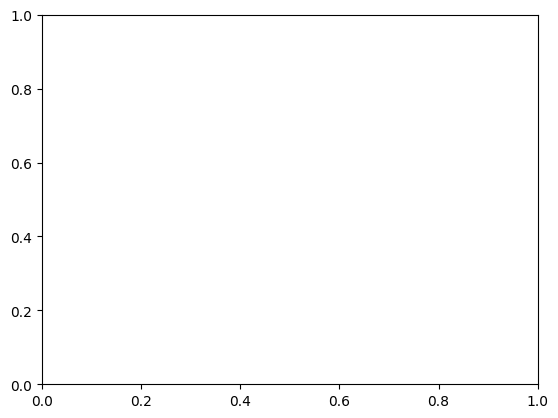

In [52]:
plt.plot(lap_times_race_mean)